In [4]:
# tf.keras.utils.image_dataset_from_directory
# tf.keras.layers.experimental.preprocessing
# tf.keras.applications.efficientB0()
# Functional API. the data you want to compute in layer can be peformed with customized operation then take into the layer operation later
# tf.keras.Model


import tensorflow as tf
import pandas as pd
import numpy as np
# but need to import once the server is restart or re-allocated for the client.
import helper_functions as hf
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory;
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
from sklearn.compose import make_column_transformer




import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy
import os
import random


## 2022.06.29 - Transfer Learning 1

### Data Collection

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-01 01:21:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-01 01:21:53 (61.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-07-01 01:21:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 173.194.202.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   199MB/s    in 14s     

2022-07-01 01:22:11 (107 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
hf.unzip_data("./101_food_classes_10_percent.zip")

In [ ]:
#hf.walk_through_dir("./101_food_classes_10_percent")

In [6]:
IMG_SIZE=(224,224)
BATCH_SIZE = 32

train_dir = "./101_food_classes_10_percent/train"
test_dir = "./101_food_classes_10_percent/test"

train_data_101_10_percent = image_dataset_from_directory(train_dir,
                                          image_size = IMG_SIZE,
                                          label_mode="categorical",
                                          batch_size = BATCH_SIZE)

# want to test data in order
test_data_101_10_percent = image_dataset_from_directory(test_dir,
                                          image_size = IMG_SIZE,
                                          label_mode="categorical",
                                          batch_size = BATCH_SIZE,
                                          shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Model: 101 classes of 10 percent data
- Another way to do the flatten after feature extraction
  - https://stackoverflow.com/questions/46036522/defining-model-in-keras-include-top-true

#### Preprocessing & Modeling

In [ ]:
checkpoint_filepath = "101_food_classes_10_percent_checkpoint"
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath,
                                                     monitor="val_accuracy",
                                                     save_best_only=True,
                                                     save_weights_only=True)

In [ ]:
data_augmentation = tf.keras.Sequential(layers=[
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2)
    #preprocessing.Rescaling(1/255.)  efficientNetB0 will auto rescale for the input                                   
],name="data_augmentation")

In [ ]:
# modeling
# want to define the own fully connected layer and output layer.
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape = IMG_SIZE+(3,),name="input_layer")
x = data_augmentation(inputs,training=True)
x = base_model(x,training=False) # batch norm is kept in the reference mode
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_2d")(x)
outputs = tf.keras.layers.Dense(len(train_data_101_10_percent.class_names),activation="softmax",name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)


16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

#### Model Training - FE

In [ ]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics = ["accuracy"])

history_0 = model.fit(train_data_101_10_percent,
          epochs = 5,
          steps_per_epoch = len(train_data_101_10_percent),
          validation_data = test_data_101_10_percent,
          validation_steps = 0.15 * len(test_data_101_10_percent),
          callbacks = [modelcheckpoint])

Epoch 1/5
189/237 [======================>.......] - ETA: 13s - loss: 3.6441 - accuracy: 0.2158

KeyboardInterrupt: ignored

#### Model Evaluation

In [ ]:
evaluation_result_101_10_perrcent_feature_extraction = model.evaluate(test_data_101_10_percent)
evaluation_result_101_10_perrcent_feature_extraction

790/790 [==============================] - 97s 123ms/step - loss: 1.9036 - accuracy: 0.5134


[1.9036449193954468, 0.5133861303329468]

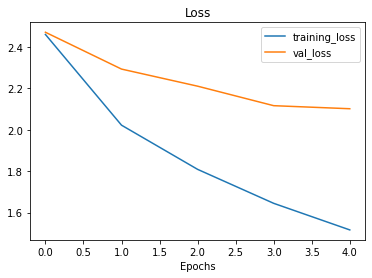

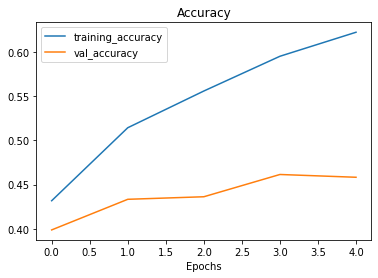

In [ ]:
hf.plot_loss_curves(history_0)

#### Fine Tuning - last 5 layers

In [ ]:
# fine tuning
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                          optimizer = tf.keras.optimizers.Adam(1e-4),
                          metrics = ["accuracy"])

for ind,lays in enumerate(model.layers[2].layers):
  print(ind,lays.name,lays.trainable,len(lays.trainable_variables))

0 input_4 False 0
1 rescaling_3 False 0
2 normalization_3 False 0
3 stem_conv_pad False 0
4 stem_conv False 0
5 stem_bn False 0
6 stem_activation False 0
7 block1a_dwconv False 0
8 block1a_bn False 0
9 block1a_activation False 0
10 block1a_se_squeeze False 0
11 block1a_se_reshape False 0
12 block1a_se_reduce False 0
13 block1a_se_expand False 0
14 block1a_se_excite False 0
15 block1a_project_conv False 0
16 block1a_project_bn False 0
17 block2a_expand_conv False 0
18 block2a_expand_bn False 0
19 block2a_expand_activation False 0
20 block2a_dwconv_pad False 0
21 block2a_dwconv False 0
22 block2a_bn False 0
23 block2a_activation False 0
24 block2a_se_squeeze False 0
25 block2a_se_reshape False 0
26 block2a_se_reduce False 0
27 block2a_se_expand False 0
28 block2a_se_excite False 0
29 block2a_project_conv False 0
30 block2a_project_bn False 0
31 block2b_expand_conv False 0
32 block2b_expand_bn False 0
33 block2b_expand_activation False 0
34 block2b_dwconv False 0
35 block2b_bn False 0
36 

In [ ]:
fine_tuning_epochs = 10
history_1 = model.fit(train_data_101_10_percent,
          epochs = fine_tuning_epochs,
          initial_epoch = history_0.epoch[-1],
          steps_per_epoch = len(train_data_101_10_percent),
          validation_data = test_data_101_10_percent,
          validation_steps = 0.15 * len(test_data_101_10_percent))

Epoch 5/10
237/237 [==============================] - 50s 180ms/step - loss: 1.3089 - accuracy: 0.6602 - val_loss: 2.0728 - val_accuracy: 0.4601
Epoch 6/10
237/237 [==============================] - 40s 169ms/step - loss: 1.1857 - accuracy: 0.6862 - val_loss: 2.0856 - val_accuracy: 0.4632
Epoch 7/10
237/237 [==============================] - 38s 159ms/step - loss: 1.1156 - accuracy: 0.7071 - val_loss: 2.1159 - val_accuracy: 0.4672
Epoch 8/10
237/237 [==============================] - 36s 151ms/step - loss: 1.0684 - accuracy: 0.7092 - val_loss: 2.1405 - val_accuracy: 0.4619
Epoch 9/10
237/237 [==============================] - 36s 149ms/step - loss: 1.0030 - accuracy: 0.7314 - val_loss: 2.0718 - val_accuracy: 0.4758
Epoch 10/10
237/237 [==============================] - 36s 150ms/step - loss: 0.9546 - accuracy: 0.7464 - val_loss: 2.0757 - val_accuracy: 0.4677


In [ ]:
model.evaluate(test_data_101_10_percent)

790/790 [==============================] - 75s 94ms/step - loss: 1.8264 - accuracy: 0.5373


[1.82637357711792, 0.5373069047927856]

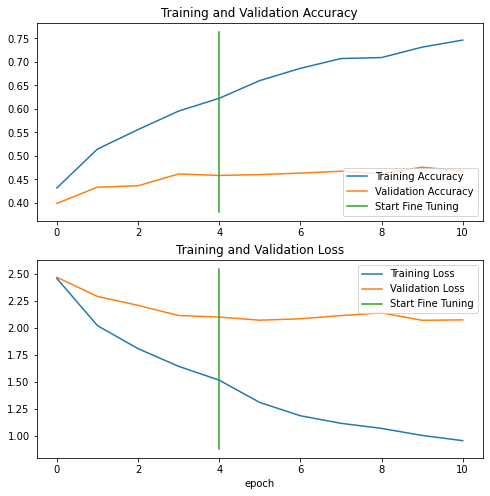

In [ ]:
hf.compare_historys(original_history = history_0,
                   new_history = history_1,
                   initial_epochs = 5)

#### Save Model

In [ ]:
# save model
model.save("./drive/MyDrive/Food_101_10_percent_fine_tuning_model")

INFO:tensorflow:Assets written to: ./drive/MyDrive/Food_101_10_percent_fine_tuning_model/assets


In [7]:
loaded_model = tf.keras.models.load_model("./drive/MyDrive/Food_101_10_percent_fine_tuning_model")
loaded_model.evaluate(test_data_101_10_percent) # should be same as above one.

## 2022.06.30 - Transfer Learning 2

### Make Prediction
- use own model
- use other pre-trained model
  - https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

In [8]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-07-01 01:24:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   108MB/s    in 0.4s    

2022-07-01 01:24:24 (108 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [9]:
hf.unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [10]:
new_loaded_model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")
new_loaded_model.evaluate(test_data_101_10_percent)

In [45]:
# get predictive probabilities with own model
pred_probs = loaded_model.predict(test_data_101_10_percent,verbose=1)

790/790 [==============================] - 124s 156ms/step


In [46]:
print(len(pred_probs),len(pred_probs[0]))
pred_classes = pred_probs.argmax(axis=1)

25250 101


### Get Actual Class through unbatch

In [47]:
actual_classes = [labels.numpy().argmax() for _,labels in test_data_101_10_percent.unbatch()]
#print(actual_classes)

In [14]:
import numpy as np

In [ ]:
tf_evaluation_result = [1.823426365852356, 0.5350494980812073]
sklearn_accuracy_result = accuracy_score(y_true=actual_classes,y_pred=pred_classes)

In [ ]:
np.isclose(tf_evaluation_result[-1],sklearn_accuracy_result)

False

### Create Confusion Matrix

In [ ]:
from importlib import reload 
reload(hf)

<module 'helper_functions' from '/content/helper_functions.py'>

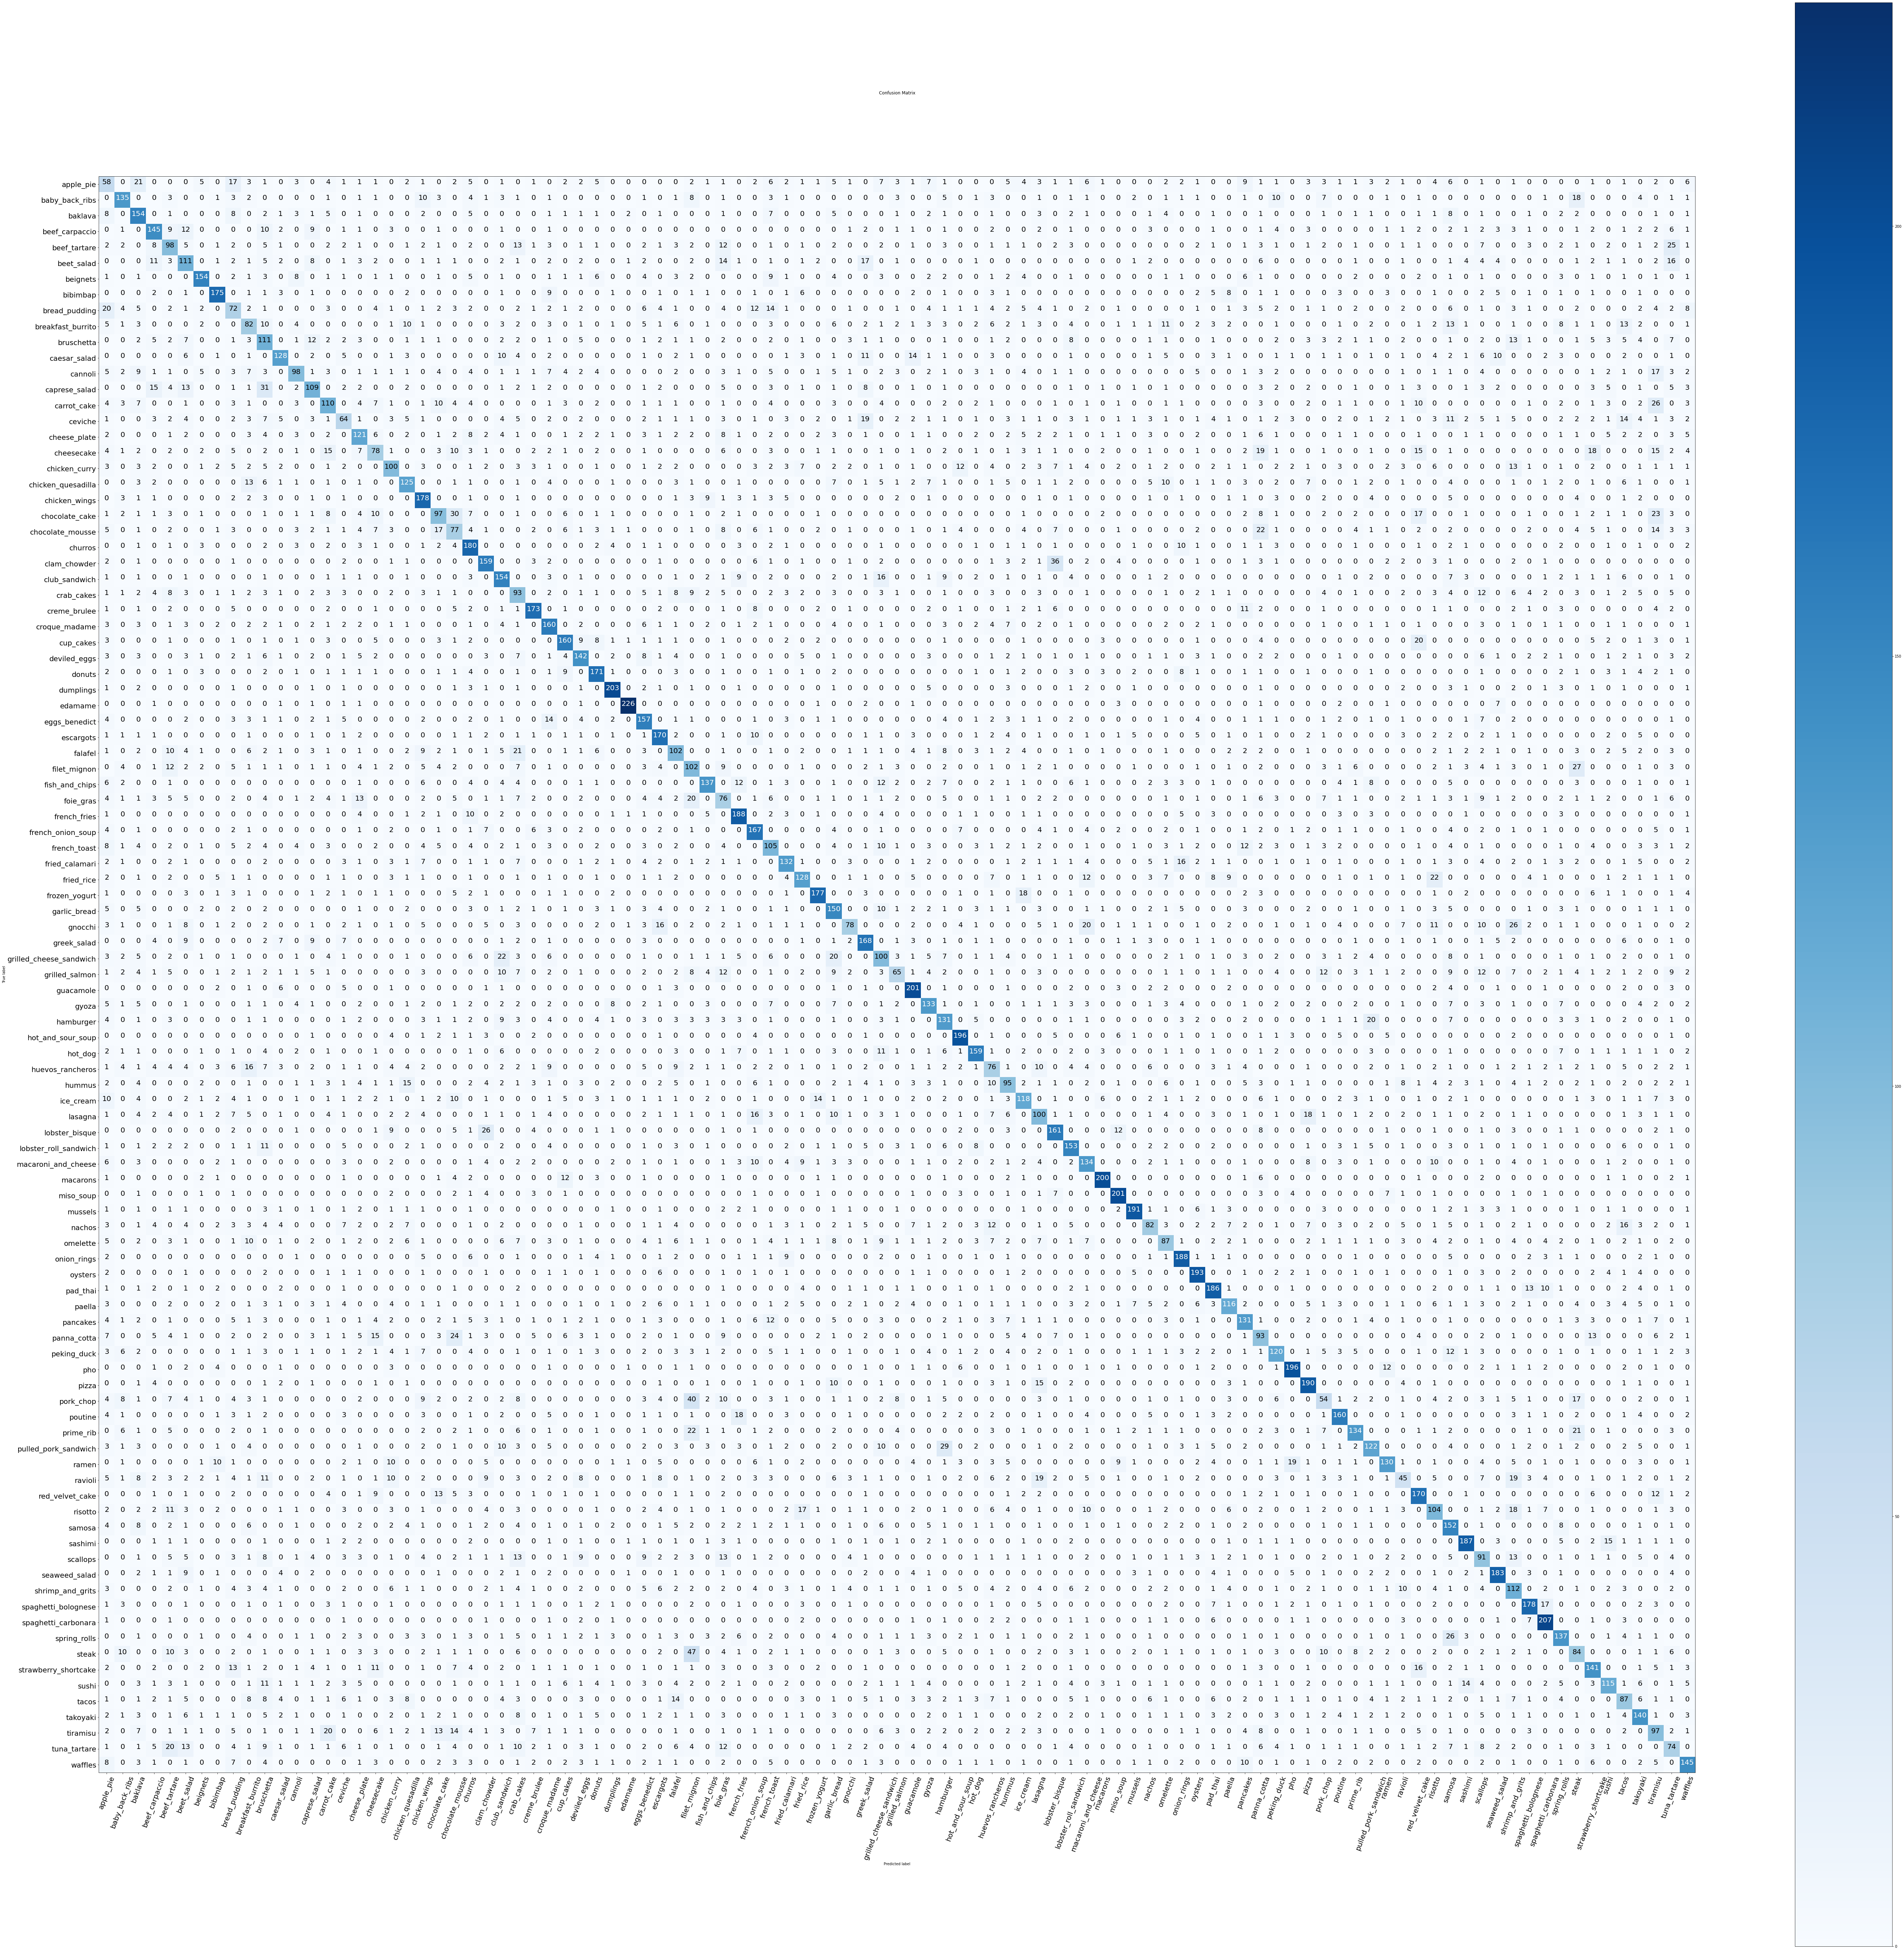

In [ ]:
hf.make_confusion_matrix(actual_classes,
                         pred_classes,
                         classes = test_data_101_10_percent.class_names,
                         figsize=(100,100),
                         text_size=20,
                         savefig=True)

### Classification Report
- summarize the comparison between actual class and pred class for each kind of class

In [35]:
cr = classification_report(y_true=actual_classes,y_pred=pred_classes,output_dict = True)
print(cr)

ValueError: ignored

### F1-Score & Sorting

In [36]:
class_names = test_data_101_10_percent.class_names

In [37]:
f1_score_dict = dict()
for k,v in cr.items():
  if k=="accuracy":
    break
  f1_score_dict[class_names[int(k)]] = v["f1-score"]

NameError: ignored

In [33]:
f1_score_df = pd.DataFrame(data={
    "class_names":f1_score_dict.keys(),
    "f1-score":f1_score_dict.values()
}).sort_values("f1-score",ascending=False).reset_index(drop=True)

ValueError: ignored

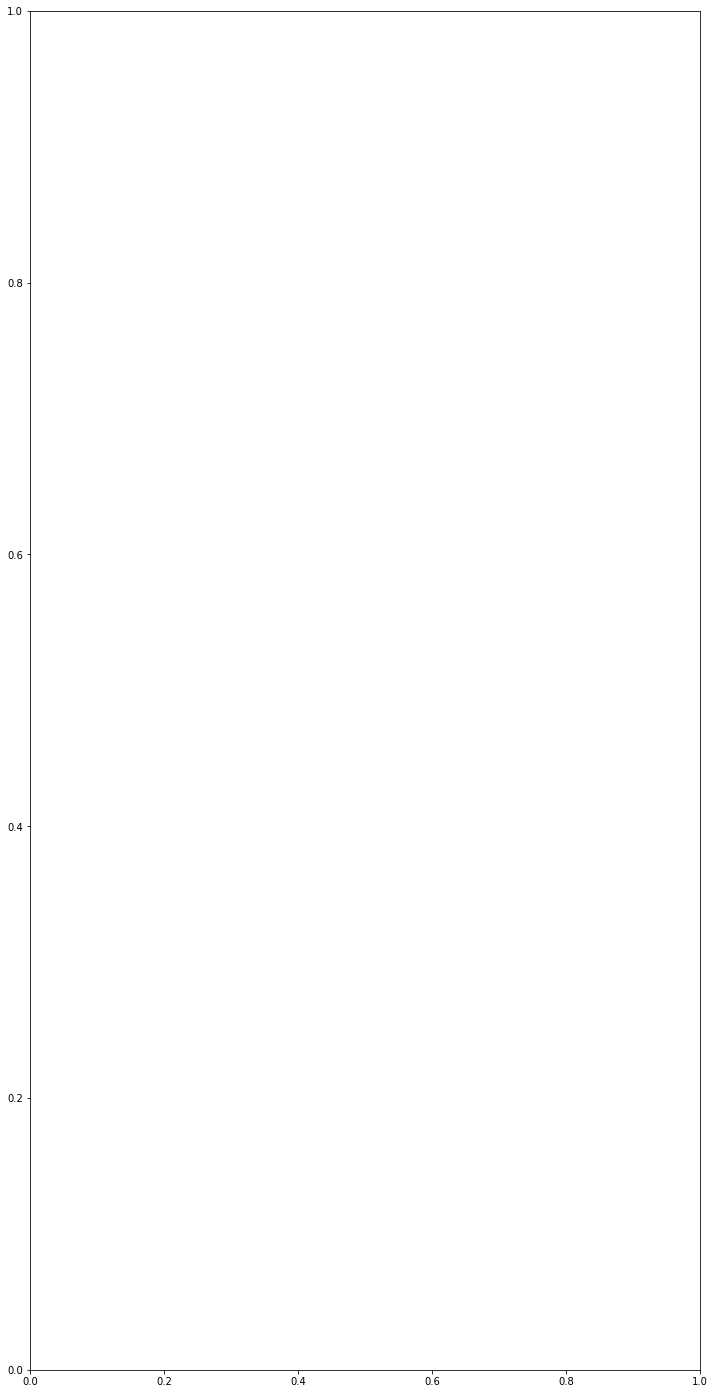

In [34]:
# plot F1 score with barh
f1_score_list = f1_score_df["f1-score"]
fig, ax = plt.subplots(figsize=(12,25))
bar_plot = ax.barh(range(len(class_names)),f1_score_list, height=0.8)
ax.set_yticks(range(len(class_names)))
ax.set_yticklabels(f1_score_df["class_names"])
ax.set_xlabel("F1 Score")
ax.set_title("F1 Score on each class")

# generate the text on the horizontal bar chat.
def autolabel(bar_plot):
    for idx,rect in enumerate(bar_plot):
        val = f1_score_list[idx]
        ax.text(0.01, idx+.25, f"{val*100:.4f}%", color = 'black',)
autolabel(bar_plot)

ax.invert_yaxis()

## 2022.07.01 - Transfer Learning 3

### A function to show the image/pred

In [16]:
def load_and_prep_image(filename, img_shape=224, scale=True):

  # convert file to 0-d string tensor
  img = tf.io.read_file(filename)
  # convert the img to tensor
  img = tf.io.decode_image(img,channels = 3)

  # resize to fit the input
  img = tf.image.resize(img,[img_shape,img_shape])

  # rescale if need
  img = img/255. if scale else img

  return img

In [48]:
class_names = test_data_101_10_percent.class_names
class_names[-1]

'waffles'

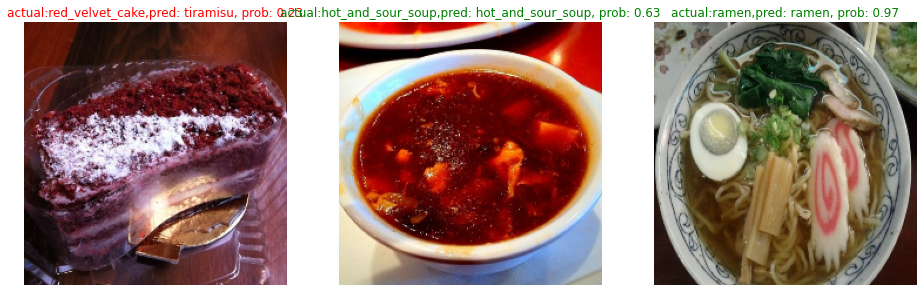

In [49]:
import random
import os
plt.figure(figsize=(16,9))
n=3
for i in range(n):
  random_class = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + random_class)) 
  filepath = test_dir + "/" + random_class + "/" + filename

  img = load_and_prep_image(filepath,scale=False)
  pred_prob = loaded_model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_prob.argmax()]
  if pred_class == random_class:
    title_color = "green"
  else:
    title_color = "red"
  
  plt.subplot(1,n,i+1)
  plt.title(f"actual:{random_class},pred: {pred_class}, prob: {pred_prob.max():.2f}",color = title_color)
  plt.imshow(img/255.)
  plt.axis(False)

### Find out the most wrong prediction
- find out the maximum prediction probabilitieis against the wrong class
  - can think about it should be 
    - data issue
    - confusion issue
- use pandas to view the prediction result

In [43]:
# get filepaths. BTW tensor can also put the image file path.
filepaths = [f.numpy() for f in test_data_101_10_percent.list_files("/content/101_food_classes_10_percent/test/*/*.jpg")]
filepaths[:10]

array([0.37143493, 0.80090046, 0.6878059 , ..., 0.51213413, 0.38260314,
       0.32467774], dtype=float32)

In [66]:
pred_df = pd.DataFrame({
    "filepath": filepaths,
    "y_true": actual_classes,
    "y_pred": pred_classes,
    "y_pred_prob":pred_probs.max(axis=1),
    "y_true_classes": [class_names[i] for i in actual_classes],
    "y_pred_classes": [class_names[i] for i in pred_classes] 
})
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("y_pred_prob",ascending=False)[:100]

In [72]:
list(top_100_wrong.itertuples())[0][1]

b'/content/101_food_classes_10_percent/test/cup_cakes/1910697.jpg'

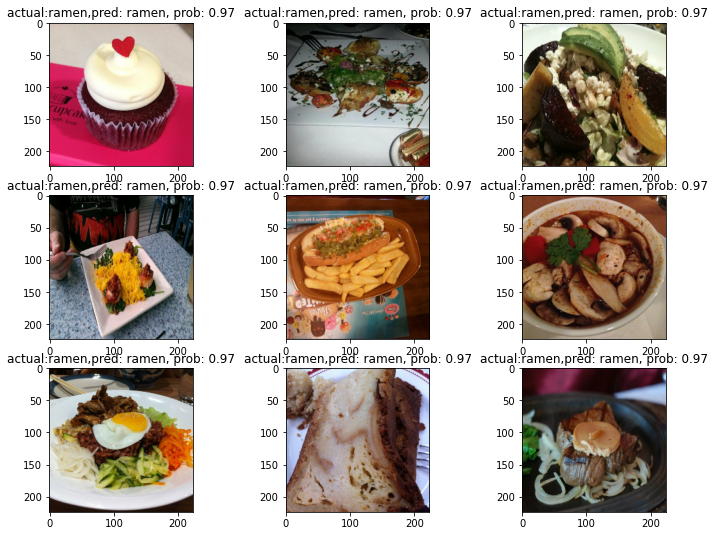

In [76]:
start_index = 0
view_to_images = 9
plt.figure(figsize=(12,9))
for ind,row in enumerate(top_100_wrong[start_index:start_index+view_to_images].itertuples()):
  plt.subplot(3,3,ind+1)
  _, fpath, _, _, y_pred_prob, y_true_class, y_pred_class, _ = row
  img = load_and_prep_image(fpath)
  plt.imshow(img)
  plt.title(f"actual:{random_class},pred: {pred_class}, prob: {pred_prob.max():.2f}")

### Making prediction on custom images

In [77]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2022-07-01 02:21:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 172.253.117.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  52.4MB/s    in 0.2s    

2022-07-01 02:21:14 (52.4 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [78]:
hf.unzip_data("custom_food_images.zip")

In [79]:
cust_file_names = os.listdir("custom_food_images")

['hamburger.jpeg',
 'steak.jpeg',
 'pizza-dad.jpeg',
 'chicken_wings.jpeg',
 'ramen.jpeg',
 'sushi.jpeg']

In [80]:
custom_filepaths = ["custom_food_images/" + img_name for img_name in os.listdir("custom_food_images")]

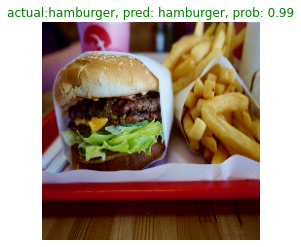

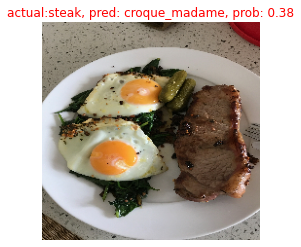

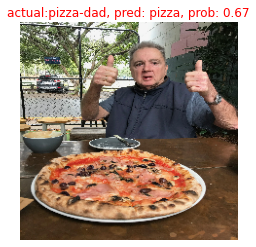

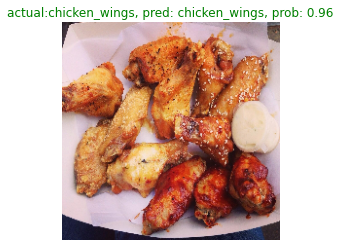

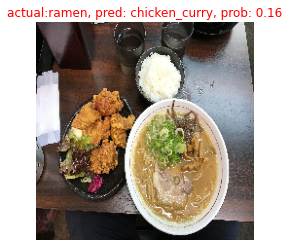

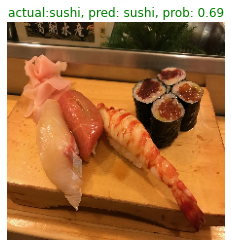

In [84]:
for custom_image in custom_filepaths:
  actual_class = custom_image.split("/")[1].split(".")[0]
  img = load_and_prep_image(custom_image,scale=False)
  cust_pred_prob = loaded_model.predict(tf.expand_dims(img,axis=0))
  cust_pred_class = class_names[cust_pred_prob.argmax(axis=1)[0]]
  if actual_class == cust_pred_class:
    title_color = "green"
  else:
    title_color = "red"
  plt.imshow(img/255.0)
  plt.title(f"actual:{actual_class}, pred: {cust_pred_class}, prob: {cust_pred_prob.max():.2f}",color=title_color)
  plt.axis(False)
  plt.show()